In [64]:
!pip install japanize-matplotlib -q

In [65]:
import numpy as np

# ソフトマックス回帰（softmax regression）

ロジスティック回帰の多クラス版

出力関数として，シグモイド関数ではなくソフトマックス関数を用いる．

## ソフトマックス関数とは
$K$個の分類問題を考える．

この時，ソフトマックス関数は$i$番目に分類される確率を与える．

$$
f(x_i) = \frac{exp(x_i)}{\sum_{k=1}^{K}exp(x_k)} \\
\, \\
i = 1, 2, \cdots, K
$$

画像データを用いた，{犬，猫，鳥，人}の４分類問題を考える．

この時，ソフトマックス関数の出力値は次のようになる．

１番目のデータサンプルによる予測値: {犬である確率，猫である確率，鳥である確率，人である確率} \
２番目のデータサンプルによる予測値: {犬である確率，猫である確率，鳥である確率，人である確率}} \
３番目のデータサンプルによる予測値: {犬である確率，猫である確率，鳥である確率，人である確率} \
. \
. \
.

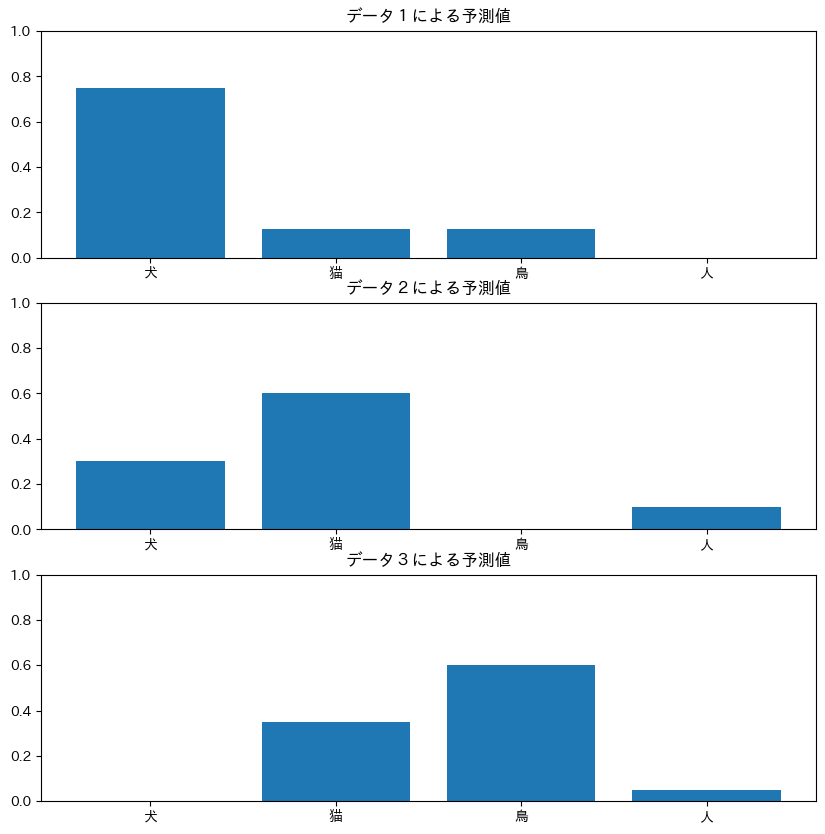

In [66]:
#@title ソフトマックス関数の出力
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

fig ,ax = plt.subplots(3, 1, figsize=(10,10))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]
ax1.set_title("データ１による予測値")
ax1.set_ylim(0, 1)
ax2.set_title("データ２による予測値")
ax2.set_ylim(0, 1)
ax3.set_title("データ３による予測値")
ax3.set_ylim(0, 1)
ax1.bar(["犬", "猫", "鳥", "人"], [0.75, 0.125, 0.125, 0])
ax2.bar(["犬", "猫", "鳥", "人"], [0.3, 0.6, 0, 0.1])
ax3.bar(["犬", "猫", "鳥", "人"], [0., 0.35, 0.6, 0.05])
plt.show()

## ソフトマックス回帰モデル

$N$次元，$M$個のデータを考える．（今回は多クラス分類問題を考えるので，yは$\{0, 1\}^K$の値を取る．）

注意するのは，パラメータ$W$と$B$，教師データ$Y$が行列になっていること．

$k$列の重みは$k$番目の分類ラベルに対するパラメータ．
$$
\begin{align}
X &=
\begin{pmatrix}
    \mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_N
\end{pmatrix} \\
W &=
\begin{pmatrix}
    \mathbf{w}_1 \\
    \mathbf{w}_2 \\
    \vdots \\
    \mathbf{w}_N
\end{pmatrix}
=
\begin{pmatrix}
    w_{11} & w_{12} & \cdots & w_{1K} \\
    w_{21} & w_{22} & \cdots & w_{2K} \\
    \vdots & \vdots & \ddots & \vdots \\
    w_{N1} & w_{N2} & \cdots & w_{NK}
\end{pmatrix} \\
B &=
\begin{pmatrix}
    \mathbf{b} \\
    \mathbf{b} \\
    \vdots \\
    \mathbf{b}
\end{pmatrix}
=
\begin{pmatrix}
    b_{1} & b_{2} & \cdots & b_{K} \\
    b_{1} & b_{2} & \cdots & b_{K} \\
    \vdots & \vdots & \ddots & \vdots \\
    b_{1} & b_{2} & \cdots & b_{K}
\end{pmatrix} \\
Y &=
\begin{pmatrix}
    \mathbf{y}_1 \\
    \mathbf{y}_2 \\
    \vdots \\
    \mathbf{y}_M
\end{pmatrix}
=
\begin{pmatrix}
    y_{11} & y_{12} & \cdots & y_{1K} \\
    y_{21} & y_{22} & \cdots & y_{2K} \\
    \vdots & \vdots & \ddots & \vdots \\
    y_{M1} & y_{M2} & \cdots & y_{MK}
\end{pmatrix} \\
\end{align}
$$

まずは，いつも通り重み付き線形和を考える．

$$
Z = XW+B = \begin{pmatrix}
    \mathbf{z}_1 \\
    \mathbf{z}_2 \\
    \vdots \\
    \mathbf{z}_M
\end{pmatrix} \\
z_m =
\begin{pmatrix}
    z_{m1} & z_{m2} & \cdots & z_{mK}
\end{pmatrix}
$$
$z_m$は$m$番目のデータの各ラベリングに対応する重み付き線形和を表す．

これの各行について，ソフトマックス関数で確率の値に変換してあげれば良い．

つまり，

$$
f(x_i) = \frac{exp(x_i)}{\sum_{k=1}^{K}exp(x_k)} \\
\, \\
i = 1, 2, \cdots, K
$$

の式を用いて，

$$
f(z_{mi}) = \frac{exp(z_{mi})}{\sum_{k=1}^{K}exp(z_{mk})} \\
\, \\
i = 1, 2, \cdots, K
$$

と変換してあげれば良い．

まずは，ここまで実装してみよう．

## 指数関数
$$
e^x = (2.71828)^x
$$

In [67]:
print(np.e ** 1)
print(np.exp(1))

2.718281828459045
2.718281828459045


In [68]:
# softmax関数を定義
def softmax(x, axis=1):
    # expのoverflowを防ぐ
    # keepdims: 次元を合わせる，max関数を使うと次元が減る（shapeが変わる）のでそれを避ける．
    x -= x.max(axis, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

class SoftmaxRegression():
    def __init__(self, in_dim, out_dim):
        """
        パラメータの初期化を行う．
        in_dim: 入力次元数, N
        out_dim: 出力次元数（ラベルの数）, K
        """
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32')
        self.b = np.zeros(shape=(1, out_dim)).astype('float32')

    def predict(self, x):
        # WRITE ME
        Z = x @ self.W + self.b
        return softmax(Z)

In [69]:
# 実験
# １０次元３つのデータサンプルを用いて５クラス分類するタスクを想定
m_data = 3
n_dim = 10
k_class = 5

smr = SoftmaxRegression(in_dim=n_dim, out_dim=k_class)
X = np.random.randn(m_data, n_dim)
print(X)
print(smr.predict(X))

[[ 1.39038115 -0.92267665  0.84071907  1.08556745 -0.98591834  1.4756062
  -1.20807096  1.26829273 -1.82117118  0.76105365]
 [-0.69755382 -0.08726751  0.74541324 -1.04882343  1.30387239  0.87614261
   2.45835133 -0.63354599 -0.43551628 -0.37657614]
 [-1.33226622  0.22736545  0.11998489  0.29868832  1.82130029  0.36059912
   0.27626538 -0.15286152  0.50126587  0.75126493]]
[[0.22903811 0.17786121 0.21503538 0.19129094 0.18677436]
 [0.18840643 0.19532004 0.21457174 0.21622179 0.18548   ]
 [0.19139618 0.19795165 0.19606846 0.19305842 0.22152529]]


## 誤差の計算

モデルの出力値が得られたので，あとは誤差を計算して勾配降下法によってパラメータを更新しよう．

今回も誤差関数としてクロスエントロピー誤差を用いる．

クロスエントロピー誤差
$$
J(\mathbf{w}, \mathbf{b}) = -\frac{1}{M}\sum_{m=1}^{M} \sum_{k=1}^{K}p_{mk}log(\hat{p}_{mk}(\mathbf{w}, \mathbf{b}))
$$

これを実装しよう．

### hint

わからなければ，行列で書き出してみよう．

そして，どことどこが掛け算されて，どことどこが足し算されているかを考えよう．

In [70]:
# log関数を定義
def np_log(x):
    """
    log関数のオーバーフローを防ぐ実装，clipで値を制限
    """
    return np.log(np.clip(x, 1e-10, 1e+10))

class SoftmaxRegression():
    def __init__(self, in_dim, out_dim):
        """
        パラメータの初期化を行う．
        in_dim: 入力次元数
        out_dim: 出力次元数（ラベルの数）
        """
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32')
        self.b = np.zeros(shape=(1, out_dim)).astype('float32')

    def predict(self, x):
        Z = x @ self.W + self.b
        return softmax(Z)

    def cost(self, y_true, y_pred):
        """
        y_true: 真の値
        y_pred: ソフトマックス後の予測値（確率値）
        """
        # WRITE ME
        J = (- y_true * np_log(y_pred)).sum(axis=1).mean()
        return J

In [71]:
y_pred = np.array([[0.98, 0.01, 0.01],
                    [0.95, 0.03, 0.02]])
y_true = np.array([[1, 0, 0],
                   [1, 0, 0]])
log_y_pred = np_log(y_pred)
print(log_y_pred)
print(y_true @ log_y_pred.T)
print(-np.trace(y_true @ log_y_pred.T)/y_pred.shape[0])
print((- y_true * np_log(y_pred)).sum(axis=1).mean())

[[-0.02020271 -4.60517019 -4.60517019]
 [-0.05129329 -3.5065579  -3.91202301]]
[[-0.02020271 -0.05129329]
 [-0.02020271 -0.05129329]]
0.035748000852535024
0.035748000852535024


In [72]:
# 実験
# １０次元３つのデータサンプルを用いて５クラス分類するタスクを想定
m_data = 3
n_dim = 10
k_class = 5

smr = SoftmaxRegression(in_dim=n_dim, out_dim=k_class)

X = np.random.randn(m_data, n_dim)
Y = np.array([[0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0],
              [1, 0, 0, 0, 0]])
Y_pred = smr.predict(X)
print(smr.cost(Y, Y_pred))

1.6273615440716445


## 勾配の計算
今回の勾配の計算はかなり難易度が高い（複雑なだけではあるが）ので，とりあえず結果だけわかれば大丈夫です．
（知りたい方は下に書いてあるので参考にしてください．）

m番目，n次元目にかかる，iクラスへのパラメータ

$$
\frac{∂J}{∂w_{ni}} = -\frac{1}{M}\sum_{m=1}^{M}(p_{mi} - \hat{p}_{mi})x_{mn}
$$

$b$はまたも，$x_{mn} = 1$とした場合と同様で，

$$
\frac{∂J}{∂b} = -\frac{1}{M}\sum_{m=1}^{M}(p_{mi} - \hat{p}_{mi})
$$

これを各パラメータについて計算して，forループで計算しても良い．

### 行列形式（授業ではこちら）

$$
Δ = Y - \hat{Y} \\
\frac{∂J}{∂W} = -\frac{1}{M}X^TΔ \\
\frac{∂J}{∂b} =  -\bar{Δ}
$$

※$\bar{Δ}$はデータの定義に基づくと，$Δ$の列ごとの平均である．

In [73]:
a = np.array([[1,1,1,1,1],
             [2,2,2,2,2],
             [1,2,3,4,5]])
a.mean(axis=0)

array([1.33333333, 1.66666667, 2.        , 2.33333333, 2.66666667])

In [74]:
# 上記の勾配に基づいて，パラメータを更新するupdate関数を定義しよう
class SoftmaxRegression():
    def __init__(self, in_dim, out_dim, momentum=False, v=0, mu=0):
        """
        パラメータの初期化を行う．
        in_dim: 入力次元数
        out_dim: 出力次元数（ラベルの数）
        """
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32')
        self.b = np.zeros(shape=(1, out_dim)).astype('float32')
        self.vw = v
        self.vb = v
        self.mu = mu
        self.momentum = momentum

    def predict(self, x):
        Z = x @ self.W + self.b
        return softmax(Z)

    def cost(self, y_true, y_pred):
        """
        y_true: 真の値
        y_pred: ソフトマックス後の予測値（確率値）
        """
        # WRITE ME
        J = (- y_true * np_log(y_pred)).sum(axis=1).mean()
        return J

    def update(self, X, Y, alpha):
        # WRITEME

        # 予測値の計算
        Y_hat = self.predict(X)

        # 誤差の計算
        delta = Y - Y_hat # WRITEME

        # 勾配の計算
        dW = -X.T @ delta / X.shape[0] # WRITEME
        db = -delta.mean(axis=0) # WRITEME

        # パラメータの更新
        if self.momentum == True:
            self.vw = self.mu * self.vw - alpha * dW
            self.vb = self.mu * self.vb - alpha * db
            self.W += self.vw
            self.b += self.vb
        else:
            self.W -= alpha * dW # WRITEME
            self.b -= alpha * db # WRITEME

        return self.cost(Y, self.predict(X))

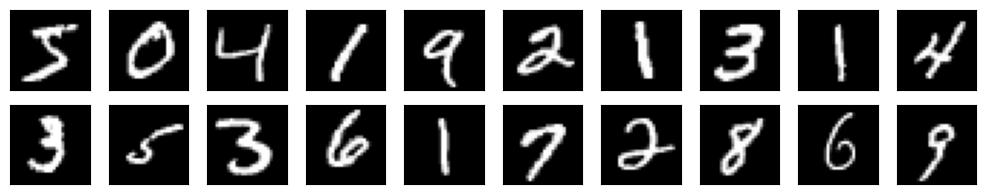

In [75]:
# mnistデータセットを学習させる
# mnist: 手書き数字画像のデータセット
from keras.datasets import mnist
(x_mnist_1, y_mnist_1), (x_mnist_2, y_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
y_mnist = np.r_[y_mnist_1, y_mnist_2]

fig = plt.figure(figsize=(10, 10))

for i in range(20):
    x = x_mnist[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [76]:
# データの前処理：正規化や一次元化したりする．
# データの分割；今回は訓練データとテストデータに分けた．
from sklearn.model_selection import train_test_split
x_mnist = x_mnist.astype('float32') / 255.
y_mnist = np.eye(N=10)[y_mnist.astype('int32').flatten()]

x_mnist = x_mnist.reshape(x_mnist.shape[0],-1)

x_train_mnist, x_test_mnist, y_train_mnist, y_test_mnist = train_test_split(x_mnist, y_mnist, test_size=10000)

In [77]:
print(x_mnist.shape)
print(x_train_mnist.shape)
print(y_train_mnist.shape)

(70000, 784)
(60000, 784)
(60000, 10)


In [94]:
# 学習
# モデルのインスタンスを生成
from sklearn.metrics import accuracy_score
sreg = SoftmaxRegression(in_dim=x_mnist.shape[1], out_dim=y_mnist.shape[1])

# momentum
# v = 10
# mu = 0.7
# sreg = SoftmaxRegression(in_dim=x_mnist.shape[1], out_dim=y_mnist.shape[1], momentum=True, v=v, mu=mu)

# バッチサイズを指定
batch_size = 300 #X_train.shape[0]

# 学習率を指定
alpha = 0.1
# alpha = 0.00001

# momentum
v = 10
mu = 0.7

# epoch数を指定
epochs = 100

# 乱数シードを固定
np.random.seed(1)

# 描画のための配列を用意
iter = int(x_train_mnist.shape[0]/batch_size)
_ = [i+1 for i in range(epochs)]
cost_J = []

for epoch in range(epochs):
    # np.random.permutation: 配列の要素をランダムに並べ替える関数
    # [1, 2, 3, 4, 5, 6] -> [5, 3, | 1, 4, | 6, 2]
    idxs = np.random.permutation(x_train_mnist.shape[0])
    idxs = np.array_split(idxs, iter)
    for idx in idxs:
        _X = x_train_mnist[idx][:]
        _y = y_train_mnist[idx][:]
        #c = sreg.update(_X, _y, alpha)
        c = sreg.update(_X, _y, alpha)
    cost_J.append(np_log(c))
    if epoch % 10 == 9:
        print("EPOCH: {}, cost: {}, accuracy: {}".format(epoch+1, c, accuracy_score(sreg.predict(x_test_mnist).argmax(axis=1), y_test_mnist.argmax(axis=1))))
    if epoch == 50 :
        alpha /= 100

EPOCH: 10, cost: 0.2966858118733459, accuracy: 0.9067
EPOCH: 20, cost: 0.3124701974214137, accuracy: 0.9128
EPOCH: 30, cost: 0.21150365373299035, accuracy: 0.9171
EPOCH: 40, cost: 0.3412472294113627, accuracy: 0.9195
EPOCH: 50, cost: 0.24633159687208414, accuracy: 0.9194
EPOCH: 60, cost: 0.20894922454840525, accuracy: 0.9209
EPOCH: 70, cost: 0.20656516050786347, accuracy: 0.9212
EPOCH: 80, cost: 0.3160477404298547, accuracy: 0.921
EPOCH: 90, cost: 0.22590935014933394, accuracy: 0.9211
EPOCH: 100, cost: 0.25410787914003663, accuracy: 0.9211


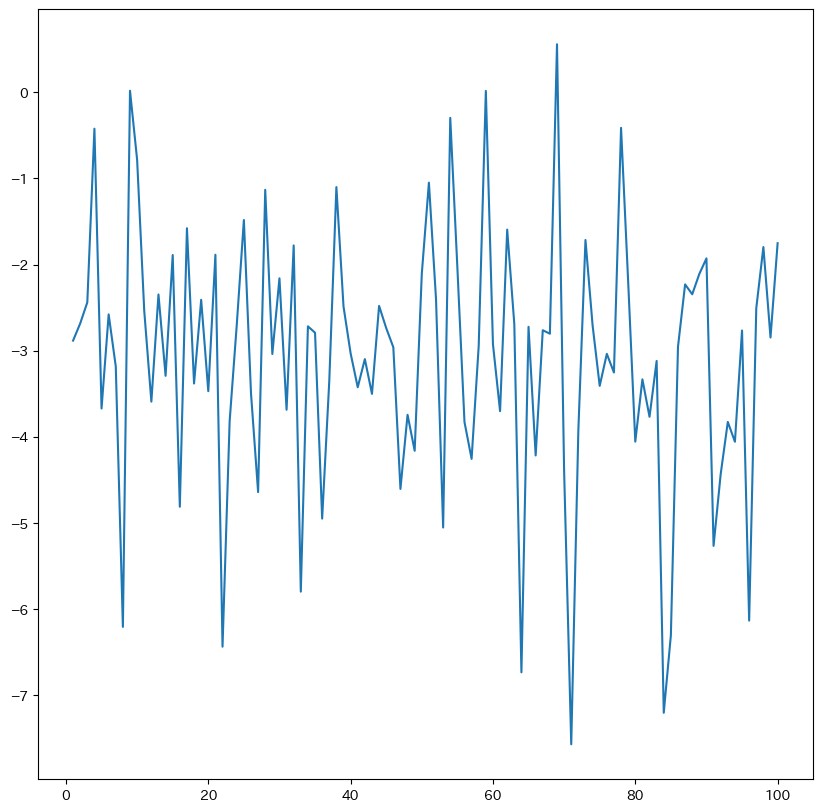

In [90]:
plt.figure(figsize=(10, 10))
plt.plot(_, cost_J)
plt.show()

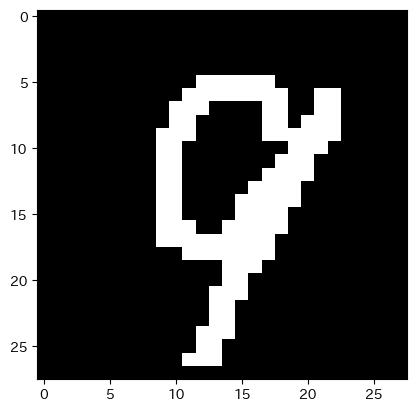

この画像は 9 です


In [91]:
# 実際の手書き数字を使って予測してみる．
import cv2
import matplotlib.pyplot as plt
path = "/content/drive/MyDrive/machine_learning/logistic_regression/samples/super9.png"
img = cv2.imread(path)
img = cv2.resize(img,(28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = (255 - img)/255
plt.imshow(img, cmap="gray")
plt.show()
img_flat = img.reshape(784, -1).flatten()
print("この画像は", sreg.predict(img_flat).argmax(), "です")

## sklearnを用いて実装する

デフォルトで，多クラス分類を行うことができる．

`sklearn.linear_model.LogisticRegression`のデフォルトでは，属性値として
`multi_class="auto", solver="lbfgs"`が設定される．

少々細かい仕様ではあるが，多クラス分類（目的変数が複数のクラス）の場合，

1. `solver="liblinear"`の時

    `multi_class="auto"(="ovr")`

2. `solver='newton-cg', 'lbfgs', 'sag', 'saga'のどれか`の時

    `multi_class="auto"(="multinomial")`

が指定される．

因みに，２番がsoftmax回帰に相当する．（入力形式は少し異なるが、、、）

なお，１番は`"one-vs-rest"`の略で，クラスの個数分の二値分類モデルを作成し，もっとも確信度の高いクラスラベルを出力するというモデルである．



In [95]:
from sklearn.linear_model import LogisticRegression

# multi_logreg = LogisticRegression(solver="lbfgs", multi_class="auto") # softmax
# multi_logreg = LogisticRegression(solver="newton-cg",multi_class="auto") # softmax
# multi_logreg = LogisticRegression(solver="sag", multi_class="auto") # softmax: 確率的勾配降下法
# multi_logreg = LogisticRegression(solver="saga",multi_class="auto") # softmax
multi_logreg = LogisticRegression(solver="liblinear", multi_class="auto") # ovr strategy

print(multi_logreg)
# fit メソッドで学習させよう
# WRITE ME
multi_logreg.fit(x_train_mnist, y_train_mnist.argmax(axis=1))
print("test accuracy:", multi_logreg.score(x_test_mnist, y_test_mnist.argmax(axis=1)))

LogisticRegression(solver='liblinear')
test accuracy: 0.9159


In [96]:
# predict メソッドで予測してみよう
# WRITE ME
print("この画像は", multi_logreg.predict(img_flat.reshape(1, -1)), "です")

この画像は [9] です


## 勾配の計算（詳細）

$$
J(\mathbf{w}, \mathbf{b}) = -\frac{1}{M}\sum_{m=1}^{M} \sum_{k=1}^{K}p_{mk}log(\hat{p}_{mk}(\mathbf{w}, \mathbf{b}))
$$

$n$次元目のカラムにかかる，$i$番目のクラス分類に使うパラメータについての偏微分を考える．

つまり，下記の偏微分を考える．

$$
\begin{align}
\frac{{\partial}J(\mathbf{w}, \mathbf{b})}{{\partial}w_{ni}}
\end{align}
$$

## 連鎖率
誤解を恐れずにいうと，複雑な関数の微分をできるだけスッキリと行う方法．

今回の関数を全て書き出すと，

$$
J(\mathbf{w}, \mathbf{b}) = -\frac{1}{M}\sum_{m=1}^{M} \sum_{k=1}^{K}p_{mk}log(\frac{exp(X\mathbf{w}_k+\mathbf{b})}{\sum_{j=1}^{K}exp(X\mathbf{w}_j+\mathbf{b})})
$$

という形になり，$w_{ni}$での微分は結構やりたくない。。。（個人の感想です）

もちろん，一つずつ書き下して$w_{ni}$で微分しても答えは出るのでそれでも大丈夫．

その場合は連鎖率の話は出てこないので，そちらの方がわかりやすい場合もある！

さて，それではここから連鎖率を使って簡単に書き換える．

### 連鎖率（１変数の場合）
多変数関数の連鎖律（Chain Rule）について簡単に解説する．

$f$を$u$の関数とする．そして，$u$は$x$の関数であるとする．
この時，

$$
\frac{df}{dx} = \frac{df}{du}\frac{du}{dx}
$$

という形で微分できる．

（例）次の関数を微分しよう．
$$
f(x) = (5x+4)^{3}
$$

（方法１）普通に展開して微分する．
$$
\begin{align}
f(x) &= (5x+4)^{3} \\
&= 125 x^3 + 300 x^2 + 240 x + 64 \\
\frac{df}{dx} &= 3 \times 125 x^2 + 2 \times 300 x + 240\\
&= 725x^2+600x+240
\end{align}
$$

（方法２）連鎖律を用いて微分する．
$$
\begin{align}
f(x) &= (5x+4)^{3} \\
u &= 5x+4\\
\end{align}
$$
とおくと，
\begin{align}
f(u) &= u^{3} \\
u &= 5x+4\\
\frac{df}{du} & = 3u^2 \\
\frac{du}{dx} & = 5
\end{align}
であり，連鎖律の式から
$$
\frac{df}{dx} = \frac{df}{du}\frac{du}{dx}\\
= 3u^2 \times 5 \\
= 15(5x+4)^2
$$

と求まる．どっちが楽かに応じて使い分ければ良い．

（展開してやりたい人はどうぞ、、、僕はあまりやりたくありません、、、笑）

### 連鎖律（２変数の場合）

$f$を$u, v$の関数とする．そして，$u, v$はどちらも$x$の関数であるとする．

この時，

$$
\frac{∂f}{∂x} = \frac{∂f}{∂u}\frac{∂u}{∂x}+\frac{∂f}{∂v}\frac{∂v}{∂x} \\
$$

である．

何が変数になっていて，どれが引数なのかを意識しよう．

（例）
$$
f(x) = \frac{e^x}{log(x)} \\
\frac{∂f}{∂x} = \frac{u}{v} \\
\frac{∂f}{∂u} = \frac{1}{v} \\
\frac{∂u}{∂x} = e^x \\
\frac{∂f}{∂v} = -\frac{u}{v^2} \\
\frac{∂v}{∂x} = \frac{1}{x}
$$
より，
$$
\begin{align}
f(x) &= \frac{e^x}{log(x)} \\
\frac{∂f}{∂x} &= \frac{∂f}{∂u}\frac{∂u}{∂x}+\frac{∂f}{∂v}\frac{∂v}{∂x} \\
&= \frac{1}{v}e^x+(-\frac{u}{v^2})\frac{1}{x} \\
&= \frac{1}{log(x)}e^x-\frac{e^x}{log(x)^2}\frac{1}{x}
\end{align}
$$
### 連鎖律（多変数の場合）

$f$を$z_1, z_2, ..., z_n$の関数とする．そして，$z_1, z_2, ..., z_n$はいずれも$x$の関数であるとする．

この時，

$$
\frac{∂f}{∂x} =\sum_{i=1}^{n} \frac{∂f}{∂z_i}\frac{∂z_i}{∂x} \\
$$

である．

後に使って，勾配を導出するため例は割愛．



## 勾配の計算

さて，話を戻そう．

下記の偏微分を考える．

$$
\begin{align}
\frac{{\partial}J(\mathbf{w}, \mathbf{b})}{{\partial}w_{ni}}
\end{align}
$$

だが，これを直接求めるのは少し骨が折れる。。。

だから，先ほどのように連鎖律を上手に使って求めてみよう．

$\hat{p}_{mk} = f_{softmax}(z_1, z_2, z_3, ... , z_K), $

$z_k=w_{1k}\mathbf{x}_1+w_{2k}\mathbf{x}_2+...+w_{Nk}\mathbf{x}_N$

とすると，

$$
\begin{align}
J(\mathbf{w}, \mathbf{b}) &= -\frac{1}{M}\sum_{m=1}^{M} \sum_{k=1}^{K}p_{mk}log(\hat{p}_{mk}) = J(\hat{p}_{m1}, \hat{p}_{m2}, ..., \hat{p}_{mK}) \\
\end{align}
$$

より，

$$
\frac{∂J(\mathbf{w}, \mathbf{b})}{∂w_{ni}} = \frac{∂J(\hat{p}_{m1}, \hat{p}_{m2}, ..., \hat{p}_{mK})}{∂w_{ni}} \\
$$
であるから，連鎖律を用いて，

$$
\frac{∂J(\mathbf{w}, \mathbf{b})}{∂w_{ni}} = \frac{∂J(\hat{p}_{m1}, \hat{p}_{m2}, ..., \hat{p}_{mK})}{∂w_{ni}} = \sum_{a=1}^{K}\frac{∂J(\hat{p}_{m1}, \hat{p}_{m2}, ..., \hat{p}_{mK})}{∂\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂w_{ni}}\\
$$
さらに，
$\hat{p}_{mk} = f_{softmax}(z_1, z_2, z_3, ... , z_K), $から，

$$
\frac{∂\hat{p}_{ma}}{∂w_{ni}} = \frac{∂f_{softmax}(z_1, z_2, z_3, ... , z_K)_{ma}}{∂w_{ni}}
$$
であるから，$p$は$z_b$の関数であるとみなせて，$（b=1,...,K）$

$$
\frac{∂\hat{p}_{ma}}{∂w_{ni}} = \sum_{b=1}^{K}\frac{∂\hat{p}_{ma}}{∂z_{b}}\frac{∂z_{b}}{∂w_{ni}}
$$

まとめて書くと，（見やすさのため，$J(\mathbf{w}, \mathbf{b})=J(\hat{p}_{m1}, \hat{p}_{m2}, ..., \hat{p}_{mK})=J$とおいた）

$$
\frac{∂J}{∂w_{ni}} = \sum_{a=1}^{K}\frac{∂J}{∂\hat{p}_{ma}}\sum_{b=1}^{K}\frac{∂\hat{p}_{ma}}{∂z_{b}}\frac{∂z_{b}}{∂w_{ni}}
$$

これが簡単なのだろうか？？

→少なくとも僕は簡単だと感じます．

→計算してみるとわかる．


まずは，
$$
\frac{∂z_{b}}{∂w_{ni}}
$$
を求めよう．

$z_b$はクラスbへの線形和であるから

$$
\frac{∂z_{b}}{∂w_{ni}} = \frac{∂}{∂w_{ni}}(w_{1b}x_{m1}+w_{2b}x_{m2}+\cdots+w_{Nb}x_{mN})
$$

これをみると，$b \ne i$の時は微分の値が0になることがわかるだろうか？

つまり，
$$
\sum_{b=1}^{K}\frac{∂\hat{p}_{ma}}{∂z_{b}}\frac{∂z_{b}}{∂w_{ni}}
$$
の値のほとんどが0になるということである．書き下すと次のようになる．

$$
\sum_{b=1}^{K}\frac{∂\hat{p}_{ma}}{∂z_{b}}\frac{∂z_{b}}{∂w_{ni}}
= \frac{∂\hat{p}_{ma}}{∂z_{1}}\frac{∂z_{1}}{∂w_{ni}} + \frac{∂\hat{p}_{ma}}{∂z_{2}}\frac{∂z_{2}}{∂w_{ni}}+\cdots+\frac{∂\hat{p}_{ma}}{∂z_{i}}\frac{∂z_{i}}{∂w_{ni}}+\cdots+\frac{∂\hat{p}_{ma}}{∂z_{K}}\frac{∂z_{K}}{∂w_{ni}} \\
= \frac{∂\hat{p}_{ma}}{∂z_{1}}\times 0 + \frac{∂\hat{p}_{ma}}{∂z_{2}}\times 0+\cdots+\frac{∂\hat{p}_{ma}}{∂z_{i}}\frac{∂z_{i}}{∂w_{ni}}+\cdots+\frac{∂\hat{p}_{ma}}{∂z_{K}}\times 0 \\
= \frac{∂\hat{p}_{ma}}{∂z_{i}}\frac{∂z_{i}}{∂w_{ni}}
$$

ここで，
$$
\frac{∂z_{i}}{∂w_{ni}} = x_{mn}
$$
なので，
$$
\sum_{b=1}^{K}\frac{∂\hat{p}_{ma}}{∂z_{b}}\frac{∂z_{b}}{∂w_{ni}} = \frac{∂\hat{p}_{ma}}{∂z_{i}} x_{mn}
$$

であり，
$$
\frac{∂J}{∂w_{ni}} = \sum_{a=1}^{K}\frac{∂J}{∂\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} x_{mn}
$$
実に気持ちよく消えてくれた．

それでは，次に

$$
\sum_{a=1}^{K}\frac{∂J}{∂\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}}
$$

この部分を求める．

ここが若干大変だが，頑張ってほしい．

まず，
$$
\frac{∂J}{∂\hat{p}_{ma}}
$$
について．

$$
\frac{∂J}{∂\hat{p}_{ma}} = \frac{∂}{∂\hat{p}_{ma}}(-\frac{1}{M}\sum_{m=1}^{M} \sum_{k=1}^{K}p_{mk}log(\hat{p}_{mk}))
= -\frac{1}{M}\sum_{m=1}^{M} \frac{∂}{∂\hat{p}_{ma}}(\sum_{k=1}^{K}p_{mk}log(\hat{p}_{mk})) \\
=  -\frac{1}{M}\sum_{m=1}^{M}\frac{∂}{∂\hat{p}_{ma}}(p_{m1}log(\hat{p}_{m1})+p_{m2}log(\hat{p}_{m2})+\cdots+p_{ma}log(\hat{p}_{ma})+\cdots+p_{mK}log(\hat{p}_{mK}))
$$

であり，やはりこれも$\hat{p}_{ma}$に関係ない項は０になるので，

$$
\frac{∂J}{∂\hat{p}_{ma}} =  -\frac{1}{M}\sum_{m=1}^{M}\frac{∂}{∂\hat{p}_{ma}}(p_{m1}log(\hat{p}_{m1})+p_{m2}log(\hat{p}_{m2})+\cdots+p_{ma}log(\hat{p}_{ma})+\cdots+p_{mK}log(\hat{p}_{mK})) \\
=  -\frac{1}{M}\sum_{m=1}^{M}(p_{m1} \times 0 + p_{m2} \times 0 + \cdots + p_{ma} \times \frac{∂}{∂\hat{p}_{ma}}(log(\hat{p}_{ma})) + \cdots + p_{mK} \times 0)\\
=  -\frac{1}{M}\sum_{m=1}^{M}p_{ma}\frac{∂}{∂\hat{p}_{ma}}(log(\hat{p}_{ma}))
$$

ここで，対数関数の微分を用いて（ロジスティック回帰の資料を参照 or Google先生に聞いてください），

$$
\frac{∂J}{∂\hat{p}_{ma}} =  -\frac{1}{M}\sum_{m=1}^{M}\frac{p_{ma}}{\hat{p}_{ma}}
$$

となる．

ここまでをまとめると，

$$
\frac{∂J}{∂w_{ni}} =  -\frac{1}{M}\sum_{m=1}^{M}\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} x_{mn}
$$

となる．

次に，

$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}}
$$
を求める．

とりあえず，書き下してみよう．

$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} \\
= \frac{p_{m1}}{\hat{p}_{m1}}\frac{∂\hat{p}_{m1}}{∂z_{i}}+\frac{p_{m2}}{\hat{p}_{m2}}\frac{∂\hat{p}_{m2}}{∂z_{i}} + \cdots + \frac{p_{mi}}{\hat{p}_{mi}}\frac{∂\hat{p}_{mi}}{∂z_{i}} + \cdots + \frac{p_{mK}}{\hat{p}_{mK}}\frac{∂\hat{p}_{mK}}{∂z_{i}}
$$

ここで，softmax関数の微分が必要になるので，微分しておく．

そのための準備として，商の微分公式を導入しておく．

## 商の微分
呪文のように唱えて覚えるといい。笑
（僕が高校の時はそんな感じで覚えました。笑）

分母二乗して，（分子微分かける分母そのまま）引く（分子そのままかける分母微分）~

$$
\frac{d}{dx}\frac{f(x)}{g(x)} = \frac{f^{\prime}(x)g(x)-f(x)g^{\prime}(x)}{g(x)^2}
$$

というわけで，これを使ってsoftmax関数を微分する．

下記にsoftmax関数を再掲する．
なおこれは，クラスiに対する確率と見做せる．

又，簡単のため$\sum_{j=1}^{K}exp(x_j)=S$とおく
$$
f(x_1, x_2, ..., x_K)_i = \frac{exp(x_i)}{\sum_{j=1}^{K}exp(x_j)}= \frac{exp(x_i)}{S} \\
$$

それでは早速，微分してみると以下のような結果になる．（実際にやってみてほしい）

$$
\frac{\partial f}{\partial x_{l}} = \left\{
\begin{array}{l}
\frac{exp(x_i)(S-exp(x_i))}{S^2}（l=i） \\
\frac{-exp(x_i)exp(x_l)}{S^2}（l \ne i）
\end{array}
\right.
$$

これを使って，

$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} \\
= \frac{p_{m1}}{\hat{p}_{m1}}\frac{∂\hat{p}_{m1}}{∂z_{i}}+\frac{p_{m2}}{\hat{p}_{m2}}\frac{∂\hat{p}_{m2}}{∂z_{i}} + \cdots + \frac{p_{mi}}{\hat{p}_{mi}}\frac{∂\hat{p}_{mi}}{∂z_{i}} + \cdots + \frac{p_{mK}}{\hat{p}_{mK}}\frac{∂\hat{p}_{mK}}{∂z_{i}}
$$

を求める．

先ほどのsoftmax関数の微分値を使って，
$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} \\
= \frac{p_{m1}}{\hat{p}_{m1}}\frac{∂\hat{p}_{m1}}{∂z_{i}}+\frac{p_{m2}}{\hat{p}_{m2}}\frac{∂\hat{p}_{m2}}{∂z_{i}} + \cdots + \frac{p_{mi}}{\hat{p}_{mi}}\frac{∂\hat{p}_{mi}}{∂z_{i}} + \cdots + \frac{p_{mK}}{\hat{p}_{mK}}\frac{∂\hat{p}_{mK}}{∂z_{i}}\\
= \frac{p_{m1}}{\hat{p}_{m1}} \times \frac{-exp(z_1)exp(z_i)}{S^2} + \frac{p_{m2}}{\hat{p}_{m2}} \times \frac{-exp(z_2)exp(z_i)}{S^2} + \cdots \\
+ \frac{p_{mi}}{\hat{p}_{mi}} \times \frac{exp(z_i)(S-exp(z_i))}{S^2} + \cdots + \frac{p_{mK}}{\hat{p}_{mK}}\times \frac{-exp(z_K)exp(z_i)}{S^2}
$$

$$
\hat{p}_{mk} = \frac{exp(z_k)}{S}
$$
なので，

$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} \\
= \frac{p_{m1}}{\hat{p}_{m1}} \times \frac{-exp(z_1)exp(z_i)}{S^2} + \frac{p_{m2}}{\hat{p}_{m2}} \times \frac{-exp(z_2)exp(z_i)}{S^2} + \cdots \\
+ \frac{p_{mi}}{\hat{p}_{mi}} \times \frac{exp(z_i)(S-exp(z_i))}{S^2} + \cdots + \frac{p_{mK}}{\hat{p}_{mK}}\times \frac{-exp(z_K)exp(z_i)}{S^2} \\
= -p_{m1}\hat{p}_{mi}-p_{m2}\hat{p}_{mi}-\cdots+p_{mi}(1-\hat{p}_{mi})-\cdots-p_{mK}\hat{p}_{mi}\\
= p_{mi} - \hat{p}_{mi}\sum_{a=1}^{K}p_{ma}
$$

ここで，$p_{ma}$はa番目のクラスかどうかを表している教師データであり，その総和は1であるから

$$
\sum_{a=1}^{K}\frac{p_{ma}}{\hat{p}_{ma}}\frac{∂\hat{p}_{ma}}{∂z_{i}} \\
= p_{mi} - \hat{p}_{mi}\sum_{a=1}^{K}p_{ma}
= p_{mi} - \hat{p}_{mi}
$$

よって，

$$
\frac{∂J}{∂w_{ni}} = -\frac{1}{M}\sum_{m=1}^{M}(p_{mi} - \hat{p}_{mi})x_{mn}
$$

$b$はまたも，$x_{mn} = 1$とした場合と同様で，

$$
\frac{∂J}{∂b} = -\frac{1}{M}\sum_{m=1}^{M}(p_{mi} - \hat{p}_{mi})
$$

[1.10159581 1.41629565 0.58180948 1.02165521 1.78589391]
1.0000000000000002


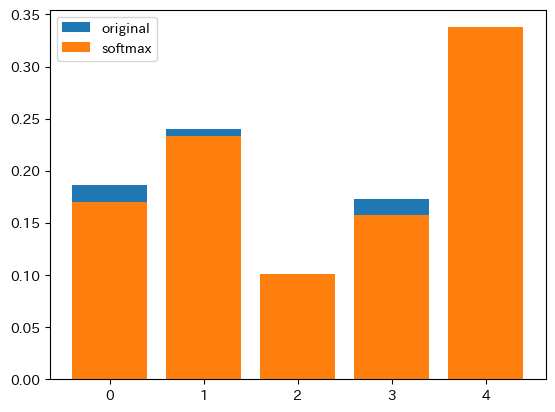

In [83]:
np.random.seed(3)
_ = np.random.uniform(0, 2, size=(5,))
_s = np.exp(_)/(np.exp(_).sum())
print(_)
print(_s.sum())
plt.bar(np.arange(5), height=_/_.sum(), label="original")
plt.bar(np.arange(5), height=_s, label="softmax")
plt.legend()
plt.show()